In [7]:
import torch
import torchvision
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
from torchinfo import summary
from torch.utils.data import DataLoader,TensorDataset,Dataset

import dl #Este código lo crea el GUI generador de Dataset
from helper_evaluation import compute_accuracy
from helper_train import train_model
from helper_plotting import plot_training_loss, plot_accuracy

In [8]:
Dataset = dl.ImageDataset()

In [9]:
print(len(Dataset))
l_ds = len(Dataset)

#Dividir el conjunto de datos en entrenamiento/validación/test
l_tr = int(round(l_ds*0.8))
l_valtest = int(l_ds - l_tr)

l_val = int(l_valtest*0.5)
l_test = int(l_valtest - l_val)

7624


In [10]:
train_set, val_set = torch.utils.data.random_split(Dataset,[l_tr,l_valtest])
val_set, test_set = torch.utils.data.random_split(val_set,
                                                  [l_val, l_test])

In [11]:
print(len(train_set))
print(len(val_set))
print(len(test_set))

6099
762
763


In [16]:
BATCH_SIZE = 32

In [17]:
train_iterator = DataLoader(train_set,
                            batch_size = BATCH_SIZE, 
                            shuffle = True, 
                            num_workers = 2)

val_iterator = DataLoader(val_set,
                          batch_size = BATCH_SIZE)

test_iterator = DataLoader(test_set,
                           batch_size = BATCH_SIZE)

In [20]:
for image, label in train_iterator:
    print(image.shape)
    print(label.shape)
    break

torch.Size([32, 3, 32, 32])
torch.Size([32])


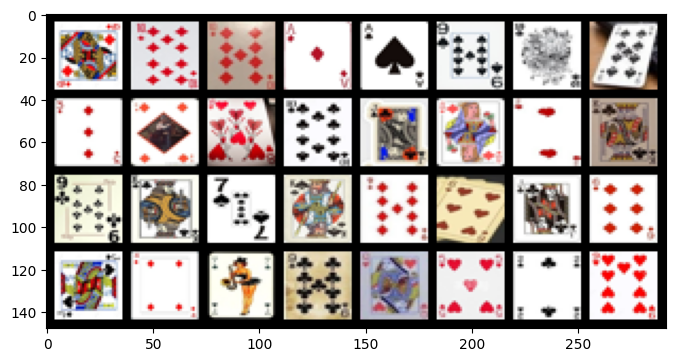

In [23]:
grid = torchvision.utils.make_grid(image, 8, 4)
plt.figure(figsize=(8,8))
plt.imshow(F.to_pil_image(grid))

In [24]:
import timm

In [26]:
all_models = timm.list_models('mob*')
len(all_models)
all_models

['mobilenetv2_035',
 'mobilenetv2_050',
 'mobilenetv2_075',
 'mobilenetv2_100',
 'mobilenetv2_110d',
 'mobilenetv2_120d',
 'mobilenetv2_140',
 'mobilenetv3_large_075',
 'mobilenetv3_large_100',
 'mobilenetv3_rw',
 'mobilenetv3_small_050',
 'mobilenetv3_small_075',
 'mobilenetv3_small_100',
 'mobileone_s0',
 'mobileone_s1',
 'mobileone_s2',
 'mobileone_s3',
 'mobileone_s4',
 'mobilevit_s',
 'mobilevit_xs',
 'mobilevit_xxs',
 'mobilevitv2_050',
 'mobilevitv2_075',
 'mobilevitv2_100',
 'mobilevitv2_125',
 'mobilevitv2_150',
 'mobilevitv2_175',
 'mobilevitv2_200']

In [45]:
model = timm.create_model('mobilenetv3_small_050', 
                          num_classes = 53, 
                          pretrained = True,
                          in_chans = 3)

In [46]:
model

MobileNetV3(
  (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): Hardswish()
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
        (bn1): BatchNormAct2d(
          16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): ReLU(inplace=True)
          (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
          (gate): Hardsigmoid()
        )
        (conv_pw): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          8

In [47]:
summary(model, (32,3,32,32))

Layer (type:depth-idx)                        Output Shape              Param #
MobileNetV3                                   [32, 53]                  --
├─Conv2d: 1-1                                 [32, 16, 16, 16]          432
├─BatchNormAct2d: 1-2                         [32, 16, 16, 16]          32
│    └─Identity: 2-1                          [32, 16, 16, 16]          --
│    └─Hardswish: 2-2                         [32, 16, 16, 16]          --
├─Sequential: 1-3                             [32, 288, 1, 1]           --
│    └─Sequential: 2-3                        [32, 8, 8, 8]             --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 8, 8, 8]             600
│    └─Sequential: 2-4                        [32, 16, 4, 4]            --
│    │    └─InvertedResidual: 3-2             [32, 16, 4, 4]            1,512
│    │    └─InvertedResidual: 3-3             [32, 16, 4, 4]            2,552
│    └─Sequential: 2-5                        [32, 24, 2, 2]            --
│    │    └─

In [48]:
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [49]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(2.2280)

In [50]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight True
bn1.weight True
bn1.bias True
blocks.0.0.conv_dw.weight True
blocks.0.0.bn1.weight True
blocks.0.0.bn1.bias True
blocks.0.0.se.conv_reduce.weight True
blocks.0.0.se.conv_reduce.bias True
blocks.0.0.se.conv_expand.weight True
blocks.0.0.se.conv_expand.bias True
blocks.0.0.conv_pw.weight True
blocks.0.0.bn2.weight True
blocks.0.0.bn2.bias True
blocks.1.0.conv_pw.weight True
blocks.1.0.bn1.weight True
blocks.1.0.bn1.bias True
blocks.1.0.conv_dw.weight True
blocks.1.0.bn2.weight True
blocks.1.0.bn2.bias True
blocks.1.0.conv_pwl.weight True
blocks.1.0.bn3.weight True
blocks.1.0.bn3.bias True
blocks.1.1.conv_pw.weight True
blocks.1.1.bn1.weight True
blocks.1.1.bn1.bias True
blocks.1.1.conv_dw.weight True
blocks.1.1.bn2.weight True
blocks.1.1.bn2.bias True
blocks.1.1.conv_pwl.weight True
blocks.1.1.bn3.weight True
blocks.1.1.bn3.bias True
blocks.2.0.conv_pw.weight True
blocks.2.0.bn1.weight True
blocks.2.0.bn1.bias True
blocks.2.0.conv_dw.weight True
blocks.2.0.bn2.weigh

In [51]:
for param in model.parameters():
    param.requires_grad = False

In [52]:
model.classifier.weight.requires_grad = True
model.classifier.bias.requires_grad = True

In [53]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

conv_stem.weight False
bn1.weight False
bn1.bias False
blocks.0.0.conv_dw.weight False
blocks.0.0.bn1.weight False
blocks.0.0.bn1.bias False
blocks.0.0.se.conv_reduce.weight False
blocks.0.0.se.conv_reduce.bias False
blocks.0.0.se.conv_expand.weight False
blocks.0.0.se.conv_expand.bias False
blocks.0.0.conv_pw.weight False
blocks.0.0.bn2.weight False
blocks.0.0.bn2.bias False
blocks.1.0.conv_pw.weight False
blocks.1.0.bn1.weight False
blocks.1.0.bn1.bias False
blocks.1.0.conv_dw.weight False
blocks.1.0.bn2.weight False
blocks.1.0.bn2.bias False
blocks.1.0.conv_pwl.weight False
blocks.1.0.bn3.weight False
blocks.1.0.bn3.bias False
blocks.1.1.conv_pw.weight False
blocks.1.1.bn1.weight False
blocks.1.1.bn1.bias False
blocks.1.1.conv_dw.weight False
blocks.1.1.bn2.weight False
blocks.1.1.bn2.bias False
blocks.1.1.conv_pwl.weight False
blocks.1.1.bn3.weight False
blocks.1.1.bn3.bias False
blocks.2.0.conv_pw.weight False
blocks.2.0.bn1.weight False
blocks.2.0.bn1.bias False
blocks.2.0.conv_d

In [54]:
summary(model)

Layer (type:depth-idx)                        Param #
MobileNetV3                                   --
├─Conv2d: 1-1                                 (432)
├─BatchNormAct2d: 1-2                         32
│    └─Identity: 2-1                          --
│    └─Hardswish: 2-2                         --
├─Sequential: 1-3                             --
│    └─Sequential: 2-3                        --
│    │    └─DepthwiseSeparableConv: 3-1       (600)
│    └─Sequential: 2-4                        --
│    │    └─InvertedResidual: 3-2             (1,512)
│    │    └─InvertedResidual: 3-3             (2,552)
│    └─Sequential: 2-5                        --
│    │    └─InvertedResidual: 3-4             (6,592)
│    │    └─InvertedResidual: 3-5             (22,840)
│    │    └─InvertedResidual: 3-6             (22,840)
│    └─Sequential: 2-6                        --
│    │    └─InvertedResidual: 3-7             (9,144)
│    │    └─InvertedResidual: 3-8             (9,144)
│    └─Sequential: 2-

In [56]:
model = model.to(DEVICE)
NUM_EPOCHS = 5

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_iterator,
    valid_loader=val_iterator,
    test_loader=test_iterator,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=50)

Epoch: 001/005 | Batch 0000/0191 | Loss: 10.2183
Epoch: 001/005 | Batch 0050/0191 | Loss: 9.3731
Epoch: 001/005 | Batch 0100/0191 | Loss: 9.1963
Epoch: 001/005 | Batch 0150/0191 | Loss: 10.1392
Epoch: 001/005 | Train: 20.18% | Validation: 10.63%
Time elapsed: 1.29 min
Epoch: 002/005 | Batch 0000/0191 | Loss: 7.0178
Epoch: 002/005 | Batch 0050/0191 | Loss: 6.8470
Epoch: 002/005 | Batch 0100/0191 | Loss: 8.5060
Epoch: 002/005 | Batch 0150/0191 | Loss: 8.6644
Epoch: 002/005 | Train: 24.27% | Validation: 13.12%
Time elapsed: 2.39 min
Epoch: 003/005 | Batch 0000/0191 | Loss: 8.7389
Epoch: 003/005 | Batch 0050/0191 | Loss: 8.5542
Epoch: 003/005 | Batch 0100/0191 | Loss: 8.7283
Epoch: 003/005 | Batch 0150/0191 | Loss: 8.1797
Epoch: 003/005 | Train: 27.40% | Validation: 11.81%
Time elapsed: 3.53 min
Epoch: 004/005 | Batch 0000/0191 | Loss: 10.0205
Epoch: 004/005 | Batch 0050/0191 | Loss: 9.8616
Epoch: 004/005 | Batch 0100/0191 | Loss: 10.1662
Epoch: 004/005 | Batch 0150/0191 | Loss: 7.9023
Epo

In [58]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(15.7274)

## Entrenar sobre el modelo preentrenado

In [59]:
model = timm.create_model('mobilenetv3_small_050', 
                          num_classes = 53, 
                          pretrained = True,
                          in_chans = 3)

In [62]:
model = model.to(DEVICE)
NUM_EPOCHS = 10

optimizer = torch.optim.SGD(model.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list, train_acc_list, valid_acc_list = train_model(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_iterator,
    valid_loader=val_iterator,
    test_loader=test_iterator,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=50)

Epoch: 001/010 | Batch 0000/0191 | Loss: 2.2913
Epoch: 001/010 | Batch 0050/0191 | Loss: 2.6673
Epoch: 001/010 | Batch 0100/0191 | Loss: 2.1498
Epoch: 001/010 | Batch 0150/0191 | Loss: 2.7609
Epoch: 001/010 | Train: 36.38% | Validation: 29.79%
Time elapsed: 2.05 min
Epoch: 002/010 | Batch 0000/0191 | Loss: 2.1949
Epoch: 002/010 | Batch 0050/0191 | Loss: 2.1076
Epoch: 002/010 | Batch 0100/0191 | Loss: 2.6835
Epoch: 002/010 | Batch 0150/0191 | Loss: 2.2980
Epoch: 002/010 | Train: 38.88% | Validation: 31.89%
Time elapsed: 5.89 min
Epoch: 003/010 | Batch 0000/0191 | Loss: 2.1502
Epoch: 003/010 | Batch 0050/0191 | Loss: 2.2418
Epoch: 003/010 | Batch 0100/0191 | Loss: 1.8605
Epoch: 003/010 | Batch 0150/0191 | Loss: 2.0376
Epoch: 003/010 | Train: 42.06% | Validation: 32.02%
Time elapsed: 7.46 min
Epoch: 004/010 | Batch 0000/0191 | Loss: 2.0587
Epoch: 004/010 | Batch 0050/0191 | Loss: 1.9974
Epoch: 004/010 | Batch 0100/0191 | Loss: 1.9343
Epoch: 004/010 | Batch 0150/0191 | Loss: 2.0269
Epoch: 

In [63]:
compute_accuracy(model, test_iterator, DEVICE)

tensor(41.6776)

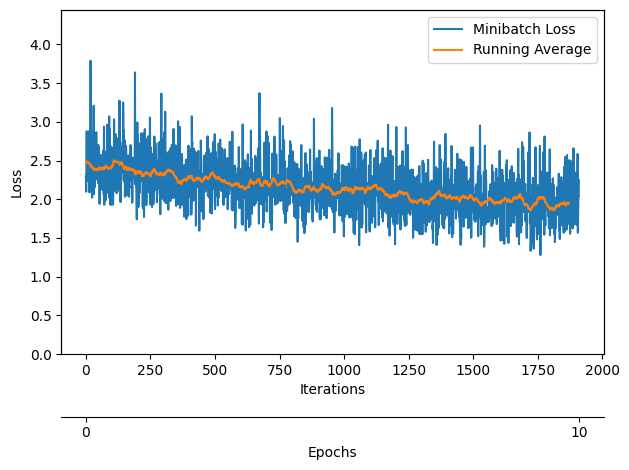

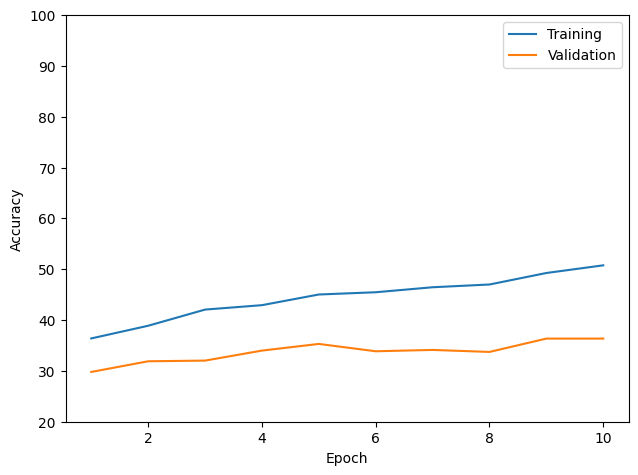

In [65]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_iterator),
                   results_dir=None,
                   averaging_iterations=40)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([20, 100])
plt.show()